In [1]:
# Initialisation
import math
import numpy as np
import matplotlib.pyplot as plt

import logging

# Function-specific loggers
def setup_logger(name, log_file, level=logging.INFO):
    """Set up a logger with a specific log file."""
    handler = logging.FileHandler(log_file, mode="w", encoding="utf-8")  # Overwrites on each run
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

# Create loggers for each function
jc_logger = setup_logger("JohnsonCook", "logs/johnson_cook.log", logging.INFO)
klaw_logger = setup_logger("Klaw", "logs/klaw.log", logging.INFO)

# Debug flags (Toggle these to enable/disable logging)
DEBUG_JC = False
DEBUG_KLAW = True

# open("debug.log", "w").close()     # Clear debug.log file manually
# logging.disable(logging.CRITICAL)  # Disables all logging

# Import the LMFIT module
import lmfit

# Definition of the cutting parameters and materials

In [2]:
# Definition of the cutting parameters
V = 100 / 60                # Cutting speed (m/s)
alpha = 13 * (math.pi/180)  # Cutting angle (radians)
w = 1.6e-3                  # Width of cut (mm)
t1 = 0.6e-3                 # Depth of cut (mm)

# Material definition
T0 = 273.15                 # Initial temperature (Kelvin)
Tw = T0 + 25                # Ambient temperature (Kelvin)
rho = 8000.0                # Density (km/m^3)
eta = 0.9                   # Value of the eta parameter
psi = 0.9                   # Value of the psi parameter
A = 553.1e6                 # A coefficient for the Johnson-Cook law (Pa)
B = 600.8e6                 # B coefficient for the Johnson-Cook law (Pa)
n = 0.234                   # n coefficient for the Johnson-Cook law
C = 0.0134                  # C coefficient for the Johnson-Cook law
m = 1                       # m coefficient for the Johnson-Cook law
Tm = 1460 + T0              # Melting temperature (Kelvin)
Epsp0 = 1                   # epislon dot coefficient for the Johnson-Cook law

In [3]:
# compute the johnson cook
def JohnsonCook(eps, epsp, T):
    result = (A + B * eps**n) * (1.0 + C * math.log(epsp / Epsp0)) * (1.0 - ((T - T0) / (Tm - T0))**m)

    if DEBUG_JC:  # Log only if debugging JohnsonCook
        jc_logger.info(f"JohnsonCook result: {result} | eps={eps}, epsp={epsp}, T={T}")

    return result

In [4]:
# Computes tThermal conductivity K 
def KLaw(T):
    result = 52.61 - 0.0281 * (T - T0)
    
    if DEBUG_KLAW:  # Log only if debugging Klaw
        klaw_logger.info(f"Klaw result: {result} | Temp={T}")
    
    return result

In [5]:
# Computes the heat capacity CP law    
def CpLaw(T):
    t=T
    x=0.466
    #return x
    return 420 + 0.504 * (T - T0)

In [6]:
# Computes the TAB temperature, returns 0 if TAB  >  Tm
def ComputeAB(): 
    # Sets TAB equal to Tw=teplota okolia s johnos cook modelu 
    TAB = Tw
    # Initialisation of the max number of loops
    maxLoops = 1000
    # Evaluates the temperature due to plastic deformation 
    while (maxLoops > 0) :
        # Computes Cp and K for TAB 
        Cp = CpLaw(TAB)
        K = KLaw(TAB)
        # Computes the flow stress of the material 
        kAB = (1.0/sqrt3) * JohnsonCook(EpsAB, EpspAB, TAB)
        # Computes the Fs value
        Fs = kAB * lAB * w
        # Computes coefficient RT 
        RTtanPhi = math.tan(phi) * (rho * Cp * V * t1) / K
        # Computes beta 
        if (RTtanPhi > 10) :
            beta = 0.3 - 0.15 * math.log10(RTtanPhi)
        else :
            beta = 0.5 - 0.35 * math.log10(RTtanPhi)
        # Computes the delta T
        deltaTsz = ((1-beta) * Fs * Vs) / (mchip * Cp)
        # Computes the new TAB temperature
        NewTAB = Tw + eta * deltaTsz
        # Tests if TAB > Tm and return zero
        if (NewTAB > Tm) : return 0, 0, 0, 0
        # Tests for the convergence of TAB (criterion is TAB_precision)
        if (abs(NewTAB - TAB) <= TAB_precision) :
            return NewTAB, Fs, deltaTsz, kAB
        # Affects the new TAB 
        TAB = NewTAB
        maxLoops -= 1
    # Oups ! no convergence at least after so many loops 
    return 0, 0, 0, 0

In [7]:
# Computes the Tc temperature
def ComputeTc(deltaTsz): 
    Tc = Tw + deltaTsz
    while (True) :
        # Computes Cp and K for temperature Tc 
        Cp = CpLaw(Tc)
        # K = KLaw(Tc) Not used here
        # Increment of temperature at the interface 
        deltaTc = Ff * Vc / (mchip * Cp)
        # New interfacial temperature TC 
        NewTc = Tw + deltaTsz + deltaTc
        # Tests for the convergence of Tc (criterion is Tc_precision)
        if (abs(NewTc - Tc) <= Tc_precision) :
            return Tc, deltaTc
        # Affects the new Tc 
        Tc = NewTc

In [8]:
# Computes the Toint and Kchip values
def Compute_Toint_Kchip():
    global lc, neq, EpsAB, EpspAB, TAB, lAB, Vs
    global Ff, Fn, Fc, Ft, Vc, t2, Epsint
    #global Epspint, Tint, R, kAB, Lambda, theta
    # Length of the first shear band lAB
    lAB = t1 / math.sin(phi)   
    # Speed along the first shear band
    Vs = V * math.cos(alpha) / math.cos(phi - alpha)   
    # Chip thickness
    t2 = t1 * math.cos(phi - alpha) / math.sin(phi)
    # Chip speed
    Vc = V * math.sin(phi) / math.cos(phi - alpha)
    # Plastic deformation in the AB zone
    gammaAB = 1/2 * math.cos(alpha) / (math.sin(phi) * math.cos(phi - alpha))
    EpsAB = gammaAB / sqrt3
    # Deformation rate in the AB zone
    gammapAB = C0 * Vs / lAB # not here
    EpspAB = gammapAB / sqrt3
    # Computes the TAB temperature
    TAB, Fs, deltaTsz, kAB = ComputeAB()
    # If TAB > Tw returns an error
    if (TAB == 0): return 0, 1e10, 0, 0
    # Computes neq using Lalwani expression
    neq = (n * B * EpsAB**n) / (A + B * EpsAB**n)
    # Computes the theta angle
    theta = math.atan(1 + math.pi/2 - 2 * phi - C0 * neq)
    # Computes the resultant force R depending on Fs and theta
    R = Fs / math.cos(theta)
    # Computes the lambda parameter
    Lambda = theta + alpha - phi
    # Computes internal forces
    Ff = R * math.sin(Lambda)
    Fn = R * math.cos(Lambda)
    Fc = R * math.cos(theta - phi)
    Ft = R * math.sin(theta - phi)
    # Computes SigmaNp 
    sigmaNmax = kAB * (1 + math.pi / 2 - 2 * alpha - 2 * C0 * neq)
    # Tool/Chip contact length
    lc = t1 * math.sin(theta) / (math.cos(Lambda) * math.sin(phi)) * (1 + C0 * neq / (3 * (1 + 2 * (math.pi/4 - phi) - C0 * neq)))
    # Stress along the interface
    Toint = Ff / (lc * w)
    # Equivalent deformation along the interface
    gammaM = lc / (delta * t2)
    gammaInt = 2 * gammaAB + gammaM / 2
    Epsint = gammaInt / sqrt3
    # Rate of deformation along the interface
    gammapInt = Vc / (delta * t2)
    Epspint = gammapInt / sqrt3
    # Contact temperature along the interface
    Tc, deltaTc = ComputeTc(deltaTsz)
    # K and Cp function of the Tc temperature
    K = KLaw(Tc)
    Cp = CpLaw(Tc)
    # Computes the RT factor
    RT = (rho * Cp * V * t1) / K
    # Computes the delta Tm value
    deltaTm = deltaTc * 10**(0.06 - 0.195 * delta * math.sqrt(RT * t2 / lc)) * math.sqrt(RT * t2 / lc)
    # Mean temperature along the interface
    Tint = Tw + deltaTsz + psi * deltaTm
    # Stress flow within the chip
    kchip = (1 / sqrt3) * JohnsonCook(Epsint, Epspint, Tint)
    # Computes the normal stress
    sigmaN = Fn / (lc * w)
    return Toint, kchip, sigmaN, sigmaNmax

# Start of the main program
Noting to change here after berfore sections 1 to 3 at the end of the program

In [9]:
nLoops_1 = 0
nLoops_2 = 0
TAB_precision = 1e-3        # Precision on the evaluation of TAB
Tc_precision = 1e-3         # Precision on the evaluation of Tc
sqrt3 = math.sqrt(3)        # Constant value for square root of 3

# Computes the mchip value from cutting parameters
mchip = rho * V * t1 * w
           
# Initialization of the internal parameters for the optimization procedure
def ReinitializeParameters(paramsOpt1, paramsOpt2):
    paramsOpt2['C0'].value = (paramsOpt2['C0'].max + paramsOpt2['C0'].min) / 2
    paramsOpt2['phi'].value = (paramsOpt2['phi'].max + paramsOpt2['phi'].min) / 2
    paramsOpt1['delta'].value = (paramsOpt1['delta'].max + paramsOpt1['delta'].min) / 2

# Internal fitting function on C0 and phi
def InternalFittingFunction(paramsOpt2):
    global C0, phi
    global Toint, kchip, sigmaN, sigmaNmax, nLoops_1
    C0 = paramsOpt2['C0'].value
    phi = paramsOpt2['phi'].value
    # Computes the internal parameters
    Toint, kchip, sigmaN, sigmaNmax = Compute_Toint_Kchip()
    # Test if there was a bug in the last run
    #if (Toint == 0): print(V * 60, t1, 180 / math.pi * phi, C0, delta, ' FAILED\n')
    # Computes the gap for the optimizer
    Gap = [(Toint - kchip), (sigmaN - sigmaNmax)]
    # Increases the number of loops
    nLoops_1 += 1
    # Return the gap value
    return Gap

# External fitting function on delta
def FittingFunction(paramsOpt1):
    global delta
    global paramsOpt2, nLoops_2
    delta = paramsOpt1['delta'].value
    fitOpt1 = lmfit.minimize(InternalFittingFunction, paramsOpt2)
    paramsOpt2 = fitOpt1.params
    # Increases the number of loops
    nLoops_2 += 1
    # Returns the cutting Force
    return [Fc]

# Optimization procedure
def Optimize(FittingFunction):
    global paramsOpt1, nLoops_1, nLoops_2
    # initialization for the number of loops
    nLoops_1 = 0
    nLoops_2 = 0
    # Calls the optimizer
    myfit = lmfit.minimize(FittingFunction, paramsOpt1)
    # Get the results
    paramsOpt1 = myfit.params

def RUN():
    # Initialisation of the Optimizer
    ReinitializeParameters(paramsOpt1, paramsOpt2)
    # Computes the solution
    Optimize(FittingFunction)

# Initialize the lists of parameters
paramsOpt1 = lmfit.Parameters()
paramsOpt2 = lmfit.Parameters()

# Initial values
paramsOpt1.add('delta', value = 0.015, min = 0.005, max = 0.2)
paramsOpt2.add('C0', value = 6, min = 2, max = 10)
paramsOpt2.add('phi', value = 26.5 * math.pi / 180, min = 8 * math.pi / 180, max = 45 * math.pi / 180)

# run the optimilisation
RUN()

#print("C0 : ", round(C0, 3))
#print("delta : ", round(delta, 3))

#print("Internal error : ", round(math.sqrt((Toint-kchip)**2 + (sigmaNmax-sigmaN)**2), 10), "Pa")
#print("Number of loops : ", nLoops_1, "and", nLoops_2)

#print("Shear angle : ", round(phi * 180/math.pi, 2), "deg")

#print("Cutting force Fc   : ", round(Fc, 1), "N (", round(Fc / w / 1000, 1), "N/mm)")
#print("Advancing force Fa : ", round(Ft, 1), "N (", round(Ft / w / 1000, 1), "N/mm)")

#print("Chip thickness : ", round(t2 * 1000, 2), "mm")
#print("Tool/Chip contact length : ", round(lc * 1000, 2), "mm")

#print("Strain in zone 1 : ", round(EpsAB, 2))
#print("Strain rate in zone 1 : ", round(EpspAB, 1), "ms-1")
#print("Temperature in zone 1 : ", round(TAB - T0, 1), "°C")
#print("Stress in zone 1 : ", round(kAB / 1e6, 1), "MPa")

#print("Strain in zone 2 : ", round(Epsint, 2))
#print("Strain rate in zone 2 : ", round(Epspint, 1), "ms-1")
#print("Temperature in zone 2 : ", round(Tint - T0, 1), "°C")
#print("Stress in zone 2 : ", round(sigmaNmax / 1e6, 1), "MPa")
	
C0_opt = C0 # = paramsOpt2['C0'].value
phi_opt = phi # = paramsOpt2['phi'].value
delta_opt = delta # = paramsOpt1['delta'].value

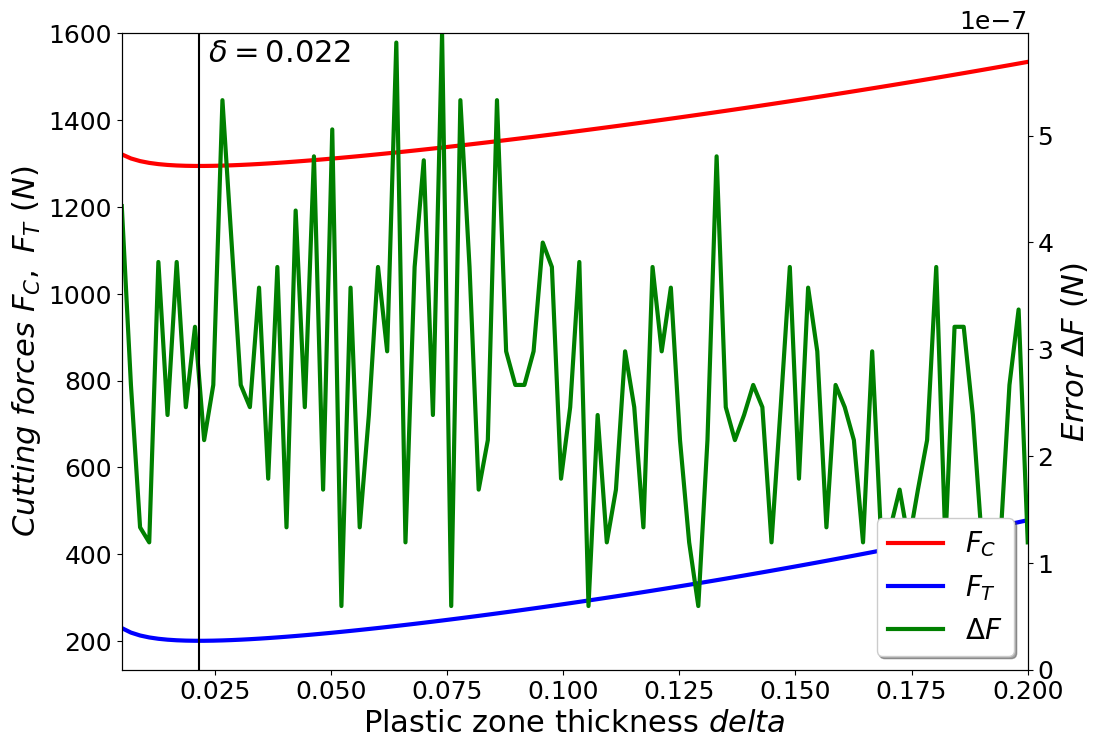

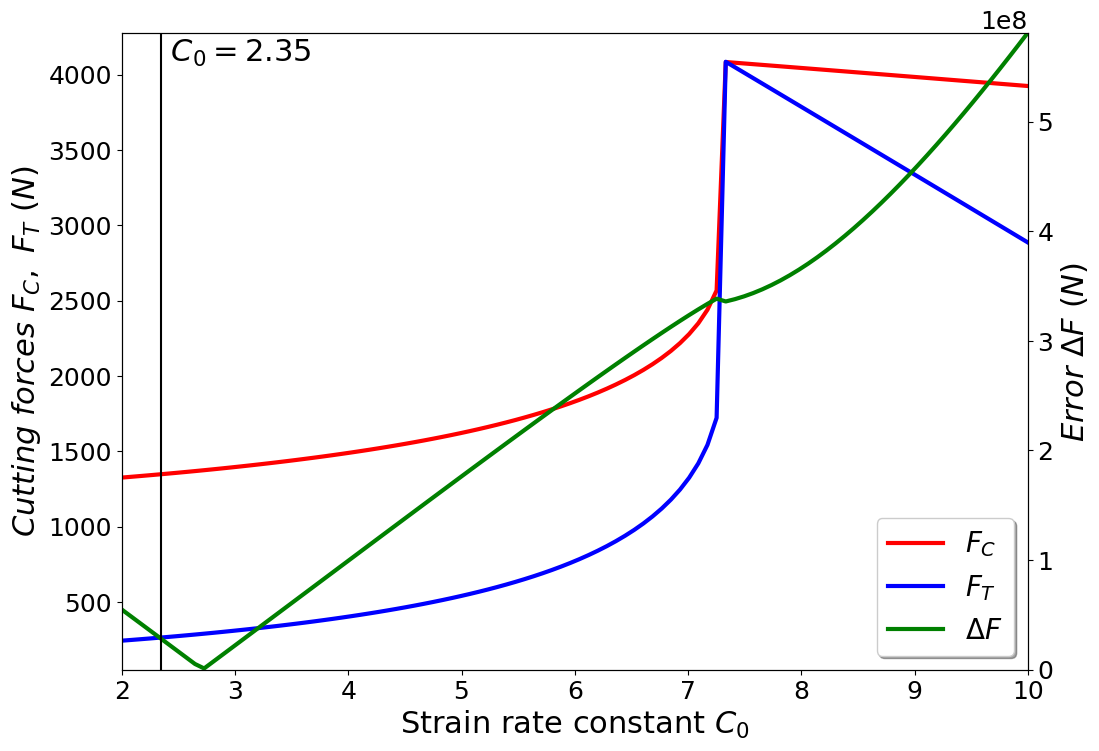

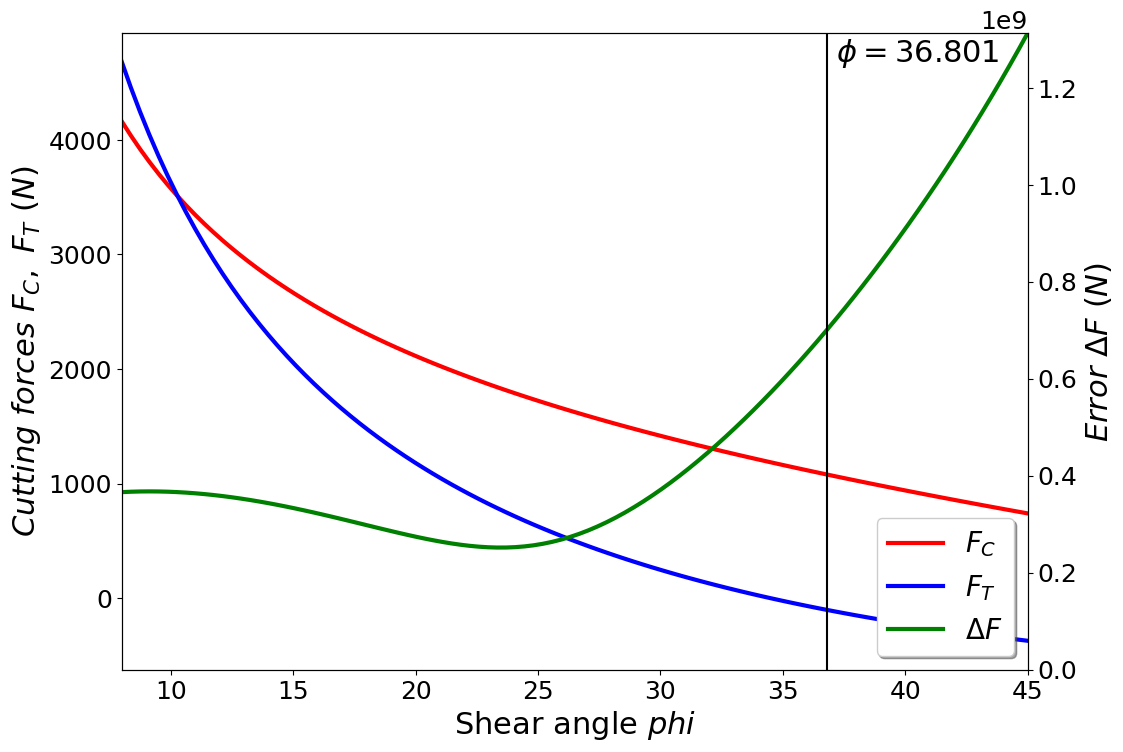

In [10]:
# --------------------------------------------------------------------------------------------------
# SECTION 1
# --------------------------------------------------------------------------------------------------
# This zone serves to generate the graphs of the evolution of 1 internal parameter vs. another one

def GetParameter(par):
    if (par in paramsOpt1.valuesdict()) :
        return paramsOpt1[par]
    if (par in paramsOpt2.valuesdict()):
        return paramsOpt2[par]
    print("Parameter", par, "is not in any of the parameters defined\n")
    return

def ParameterStudy(par, var):
    global tab, phiVary, deltaVary, C0Vary
    GetParameter(par).vary = False
    factor = 1
    if (par == 'phi') : factor = 180/math.pi
    tab = np.array([[0, 0, 0, 0, 0, 0, 0]])
    xs = np.linspace(GetParameter(par).min, GetParameter(par).max, 100, True)
    ReinitializeParameters(paramsOpt1, paramsOpt2)
    for x in xs:
        GetParameter(par).value = x
        # find the solution
        Optimize(FittingFunction)
        aa = np.array([factor*x, Fc, Ft, math.sqrt((Toint-kchip)**2+(sigmaN-sigmaNmax)**2), C0, delta, 180/math.pi*phi])
        # Corretion for delta
        if (par == 'delta'):
            if (math.sqrt((Toint-kchip)**2+(sigmaN-sigmaNmax)**2) > 1) : aa[3] = 0
        tab = np.vstack((tab, aa))
    tab = np.delete(tab, 0, 0)

    # # Plot the first Figure
    #rc('text', usetex = True)
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    fig, ax1 = plt.subplots(figsize = (11.69, 8.27))
    ax2 = ax1.twinx()
    ax2.ticklabel_format(style = 'sci', scilimits = (-2, 2))
    ax2.grid(False)
    p_Fc, = ax1.plot(tab[:, 0], tab[:, 1], 'r', linewidth = 3)
    p_Fn, = ax1.plot(tab[:, 0], tab[:, 2], 'b', linewidth = 3)
    p_C, = ax2.plot(tab[:, 0], tab[:, 3], 'g', linewidth = 3)
    locY = max(np.amax(tab[:, 1]), np.amax(tab[:, 2]))
    if (par == 'C0'):
        plt.axvline(x = C0_opt, color = 'k')
        ax1.annotate(' $C_0 = '+str(round(C0_opt, 3))+'$', xy = (C0_opt, locY), fontsize = 22)
        ax1.set_xlim([GetParameter(par).min, GetParameter(par).max])
    if (par == 'delta'):
        plt.axvline(x = delta_opt, color = 'k')
        ax1.annotate(' $\\delta = '+str(round(delta_opt, 3))+'$', xy = (delta_opt, locY), fontsize = 22)
        ax1.set_xlim([GetParameter(par).min, GetParameter(par).max])
    if (par == 'phi'):
        plt.axvline(x = 180/math.pi*phi_opt, color = 'k')
        ax1.annotate(' $\\phi = '+str(round(180/math.pi*phi_opt, 3))+'$', xy = (180/math.pi*phi_opt, locY), fontsize = 22)
        ax1.set_xlim([180/math.pi*GetParameter(par).min, 180/math.pi*GetParameter(par).max])
    ax1.set_xlabel(var, fontsize = 22)
    ax1.set_ylabel('$Cutting\\ forces\\ F_{C}, \\ F_{T}\\ (N)$', fontsize = 22)
    ax2.set_ylabel('$Error\\ \\Delta F\\ (N)$', fontsize = 22)
    ax2.set_ylim([0,tab[:, 3].max()])
    plt.legend(handles = [p_Fc, p_Fn, p_C], labels = ['$F_C$', '$F_T$', '$\\Delta F$'], fontsize = 20, fancybox = True, shadow = True, frameon = True, loc = 'lower right')
#    plt.savefig(par+'.svg', transparent = True, bbox_inches = 'tight', pad_inches = 0)
    plt.show()

ParameterStudy('delta', 'Plastic zone thickness $delta$')
ParameterStudy('C0', 'Strain rate constant $C_0$')
ParameterStudy('phi', 'Shear angle $phi$')